# Import

In [1]:
!pip install gcm-filters

In [2]:
!pip install seawater

In [1]:
from dask.distributed import Client
from dask_gateway import Gateway

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [5]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(2)

In [6]:
cluster

In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.44165f167f79407395aafb40a36d9af4/status,


In [8]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gcm_filters
from xhistogram.xarray import histogram
import seawater as sw

# Plotting params

In [9]:
plt.rcParams['figure.figsize'] = (8,5)

In [10]:
%matplotlib inline

# Load data

Load Pangeo catalog

In [11]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

Winter data:

In [25]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'time_counter':267, 'x' : -1, 'y' : -1})

In [28]:
enatl01w.chunks

Frozen(SortedKeysDict({'y': (763,), 'x': (611,), 'time_counter': (267, 267, 267, 267, 267, 267, 267, 267)}))

Summer data:

In [29]:
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'time_counter':267, 'x' : -1, 'y' : -1})

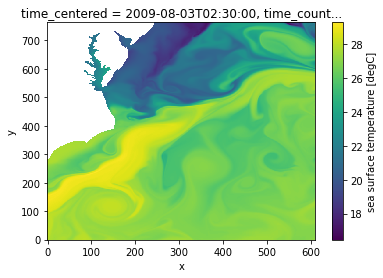

In [30]:
enatl01s.sosstsst.isel(time_counter=50).plot()

# Prepare data

## Slicing

In [31]:
enatl01w.time_counter.size

2136

In [32]:
# x_slice = slice(300,600)
# y_slice = slice(400,700)

In [33]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

In [35]:
data_slice = dict(time_counter=slice(0,-1),y=y_slice,x=x_slice)

In [36]:
coord_slice = dict(y=y_slice,x=x_slice)

## Grid

In [37]:
area = xr.DataArray((enatl01w.e1t[coord_slice] * enatl01w.e2t[coord_slice]), dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ) 
#area.plot()

Spacings:

In [38]:
dxw = xr.DataArray(enatl01w.e1u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ) # y-spacing centered at southern cell edge

In [39]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1289.53776172)

In [40]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

## Mask

In [41]:
wet_mask = xr.DataArray(enatl01w.umask[coord_slice],
                        dims=['y','x'],
                        coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
           )
#wet_mask.plot()

# Filter

## Define filter

Parameters (to determine) :

In [42]:
filter_scale=20000

In [43]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)

## Apply filter to data

In [51]:
dataset_to_filter = xr.Dataset(
                        {"sst" : enatl01w.sosstsst[data_slice],
                         "sal" : enatl01w.sosaline[data_slice],
                         "dens" : xr.apply_ufunc(sw.dens0, enatl01w.sosaline[data_slice],  enatl01w.sosstsst[data_slice], dask='parallelized'),
                         "wet_mask" : enatl01w.tmask[coord_slice]},
                        coords={'time_counter' : enatl01w[data_slice].time_counter,
                                'y':np.arange(len(enatl01w.y[y_slice])),
                                'x':np.arange(len(enatl01w.x[x_slice])),
                                'lat' : enatl01w.lat[coord_slice],
                                'lon' : enatl01w.lon[coord_slice]})

In [53]:
dataset_to_filter.chunks

Frozen(SortedKeysDict({'y': (762,), 'x': (610,), 'time_counter': (267, 267, 267, 267, 267, 267, 267, 266)}))

In [55]:
# ALLOCATION
dataset_filtered = xr.Dataset(
                        {"sst" : enatl01w.sosstsst[data_slice],
                         "sal" : enatl01w.sosaline[data_slice],
                         "dens" : dataset_to_filter.dens,
                         "dens_filtered" : dataset_to_filter.dens},
                        coords={'time_counter' : enatl01w[data_slice].time_counter,
                                'y':np.arange(len(enatl01w.y[y_slice])),
                                'x':np.arange(len(enatl01w.x[x_slice])),
                                'lat' : enatl01w.lat[coord_slice],
                                'lon' : enatl01w.lon[coord_slice]})

In [ ]:
%time dataset_filtered["sst"] = gaussian_filter.apply(dataset_to_filter.sst, dims=['y', 'x'])
%time dataset_filtered["sal"] = gaussian_filter.apply(dataset_to_filter.sal, dims=['y', 'x'])

In [59]:
%time dataset_filtered["dens_filtered"] = gaussian_filter.apply(dataset_to_filter.dens, dims=['y', 'x'])

CPU times: user 60.9 ms, sys: 4.05 ms, total: 65 ms
Wall time: 62.8 ms


Recalculate the density with the use of the filtered tempeature and salinity:

In [60]:
%time dataset_filtered["dens"] = xr.apply_ufunc(sw.dens0, dataset_filtered["sal"], dataset_filtered["sst"], dask='parallelized')

CPU times: user 8.22 ms, sys: 8 µs, total: 8.23 ms
Wall time: 7.87 ms


In [61]:
#%time dataset_filtered["dens"] = (("time_counter", "y", "x"), xr.apply_ufunc(sw.dens0, dataset_filtered["sal"], dataset_filtered["sst"], dask='parallelized'))

In [62]:
prime = xr.Dataset( {"sst" : dataset_to_filter.sst-dataset_filtered.sst,
                    "sal" : dataset_to_filter.sal-dataset_filtered.sal,
                    "dens" : dataset_filtered.dens_filtered-dataset_filtered.dens},
                    coords={'time_counter' : enatl01w[data_slice].time_counter,
                            'y':np.arange(len(enatl01w.y[y_slice])),
                            'x':np.arange(len(enatl01w.x[x_slice])),
                            'lat' : enatl01w.lat[coord_slice],
                            'lon' : enatl01w.lon[coord_slice]})

## Plot filtered fields

In [64]:
time_counter_to_plot = 1

KeyboardInterrupt: 

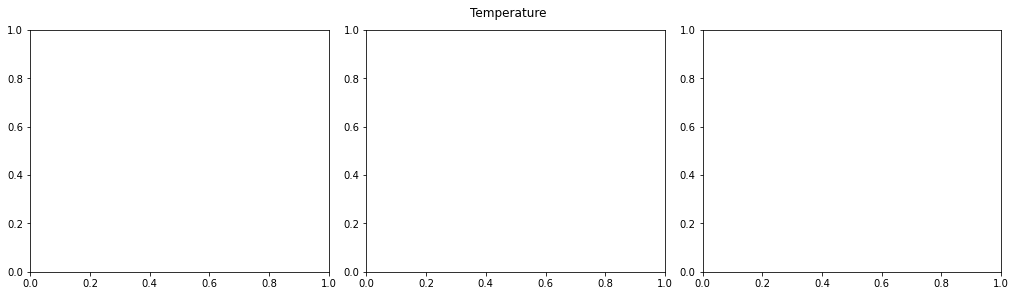

In [67]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Temperature')
(dataset_to_filter.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered: $t = T + t^\prime$')
# dataset_filtered.sst.isel(time_counter=time_counter_to_plot).plot(ax=ax[1], x='lon', y='lat')
# ax[1].set(title=r'Filtered to %2.0f km: T' % (filter_scale*0.001))
# prime.sst.isel(time_counter=time_counter_to_plot).plot(ax=ax[2], x='lon', y='lat', cmap='seismic')
# ax[2].set(title=r'Unfiltered - filtered: $t^\prime$')
plt.show()

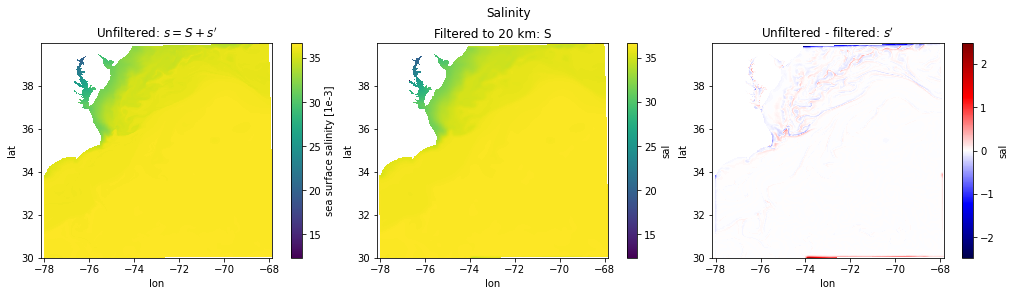

In [79]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Salinity')
dataset_to_filter.isel(time_counter=time_counter_to_plot).sal.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered: $s = S + s^\prime$')
dataset_filtered.isel(time_counter=time_counter_to_plot).sal.plot(ax=ax[1], x='lon', y='lat')
ax[1].set(title=r'Filtered to %2.0f km: S' % (filter_scale*0.001))
prime.sal.isel(time_counter=time_counter_to_plot).plot(ax=ax[2], x='lon', y='lat', cmap='seismic')
ax[2].set(title=r'Unfiltered - filtered: $s^\prime$')
plt.show()

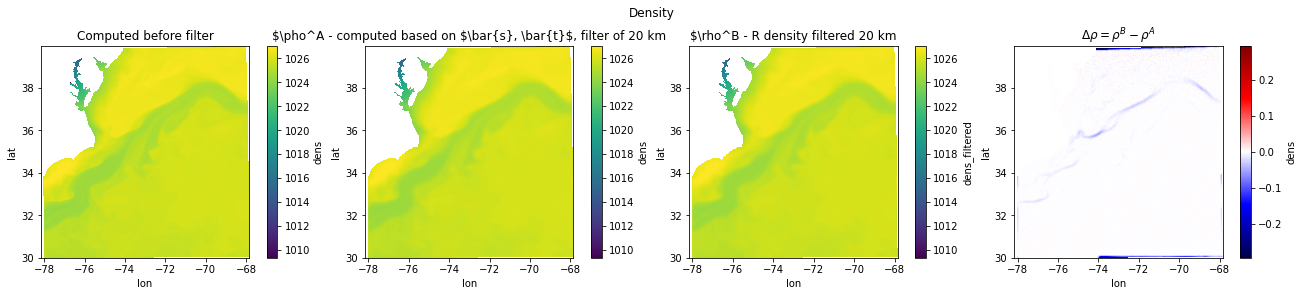

In [80]:
fig, ax = plt.subplots(ncols=4, constrained_layout=True, figsize=(18,4))
fig.suptitle('Density')
dataset_to_filter.isel(time_counter=time_counter_to_plot).dens.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Computed before filter')

dataset_filtered.isel(time_counter=time_counter_to_plot).dens.plot(ax=ax[1], x='lon', y='lat')
ax[1].set(title=r'$\pho^A - computed based on $\bar{s}, \bar{t}$, filter of %2.0f km' % (filter_scale*0.001))

dataset_filtered.isel(time_counter=time_counter_to_plot).dens_filtered.plot(ax=ax[2], x='lon', y='lat')
ax[2].set(title=r'$\rho^B - R density filtered %2.0f km' % (filter_scale*0.001))

prime.dens.isel(time_counter=time_counter_to_plot).plot(ax=ax[3], x='lon', y='lat', cmap='seismic')
ax[3].set(title=r'$\Delta \rho = \rho^B - \rho^A$')
plt.show()

Take a slice to cut-off borders

In [81]:
slice_for_filtered_data = dict(x=slice(20,-20),y=slice(20,-20))

In [82]:
slice_for_filtered_data

{'x': slice(20, -20, None), 'y': slice(20, -20, None)}

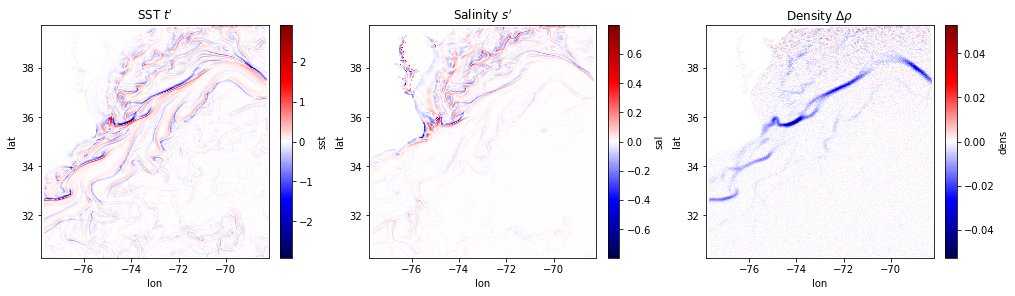

In [83]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
prime.sst[slice_for_filtered_data].isel(time_counter=time_counter_to_plot).where(dataset_to_filter.wet_mask > 0).plot(ax=ax[0],x='lon', y='lat', cmap='seismic')
prime.sal[slice_for_filtered_data].isel(time_counter=time_counter_to_plot).where(dataset_to_filter.wet_mask > 0).plot(ax=ax[1],x='lon', y='lat', cmap='seismic')
prime.dens[slice_for_filtered_data].isel(time_counter=time_counter_to_plot).where(dataset_to_filter.wet_mask > 0).plot(ax=ax[2],x='lon', y='lat', cmap='seismic')
ax[0].set(title=r'SST $t^\prime$')
ax[1].set(title=r'Salinity $s^\prime$')
ax[2].set(title=r'Density $\Delta \rho$')
plt.show()

# 1D Histograms

In [84]:
nb_of_bins = 150

In [85]:
%time binsTprime = np.linspace(prime.sst.min(), prime.sst.max(), nb_of_bins)
histTprime = histogram(prime.sst[slice_for_filtered_data], bins=[binsTprime])

CPU times: user 991 ms, sys: 378 ms, total: 1.37 s
Wall time: 1.85 s


In [86]:
%time binsSprime = np.linspace(prime.sal.min(), prime.sal.max(), nb_of_bins)
histSprime = histogram(prime.sal[slice_for_filtered_data], bins=[binsSprime])

CPU times: user 848 ms, sys: 349 ms, total: 1.2 s
Wall time: 1.51 s


In [95]:
%time binsDeltaDens = np.linspace(prime.dens.min(), prime.dens.max(), nb_of_bins)
histDeltaDens = histogram(prime.dens[slice_for_filtered_data], bins=[binsDeltaDens])

CPU times: user 44 ms, sys: 1.73 ms, total: 45.7 ms
Wall time: 43.7 ms


ZeroDivisionError: integer division or modulo by zero

In [ ]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
ax.plot((binsTprime[:-1] + np.diff(binsTprime)/2)/np.max(np.abs(binsTprime)), histTprime.values, '.-', label=r'$t^\prime$')
ax.plot((binsSprime[:-1] + np.diff(binsSprime)/2)/np.max(np.abs(binsSprime)), histSprime.values, '.-', label=r'$s^\prime$')
ax.plot((binsDeltaDens[:-1] + np.diff(binsDeltaDens)/2)/np.max(np.abs(binsDeltaDens)), histDeltaDens.values, '.-', label=r'$\Delta \rho$')
ax.set(yscale='log', xlabel='Normalized bin', ylabel='Count'); ax.grid()
ax.legend()
plt.show()

# 2D Histograms

In [ ]:
bins_T = np.linspace(dataset_to_filter.sst.min(), dataset_to_filter.sst.max(), nb_of_bins)
bins_S = np.linspace(dataset_to_filter.sal.min(), dataset_to_filter.sal.max(), nb_of_bins)

In [ ]:
%time histTS_filtered = histogram(dataset_filtered.sal[slice_for_filtered_data], dataset_filtered.sst[slice_for_filtered_data],  bins=[bins_S, bins_T])

In [ ]:
%time histTS_unfiltered = histogram(dataset_to_filter.sal[slice_for_filtered_data], dataset_to_filter.sst[slice_for_filtered_data], bins=[bins_S, bins_T])

In [ ]:
%time histTS_prime = histogram(prime.sal[slice_for_filtered_data], prime.sst[slice_for_filtered_data], bins=[binsSprime, binsTprime])

In [ ]:
max_counter = np.max([histTS_unfiltered.max(), histTS_filtered.max()])

In [ ]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))

#X, Y = np.meshgrid(bins_T[:-1] + np.diff(bins_T)/2, bins_S[:-1] + np.diff(bins_S)/2)
#hist_plot0 = ax[0].pcolormesh(X, Y, histTS_unfiltered, norm=colors.LogNorm(vmin=1, vmax=histTS_unfiltered.max()), cmap='PuBuGn')
hist_plot0 = histTS_unfiltered.T.plot(ax=ax[0], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
ax[0].set(xlabel=r'$s$', ylabel=r'$t$', title='Unfiltered')

#hist_plot0 = ax[1].pcolormesh(X, Y, histTS_filtered, norm=hist_plot0.norm, cmap=hist_plot0.cmap)
histTS_filtered.T.plot(ax=ax[1], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[1].set(xlabel=r'$\bar{s}$', ylabel=r'$\bar{t}$', title='Filtered')
ax[1].sharex(ax[0]); ax[1].sharey(ax[0])

#X, Y = np.meshgrid(binsTprime[:-1] + np.diff(binsTprime)/2, binsSprime[:-1] + np.diff(binsSprime)/2)
#hist_plot2 = ax[2].pcolormesh(X, Y, histTS_prime, norm=hist_plot0.norm, cmap=hist_plot0.cmap)
histTS_prime.T.plot(ax=ax[2], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[2].set(xlabel=r'$s^\prime$', ylabel=r'$t^\prime$', title='Prime')
#plt.colorbar(hist_plot0, ax=ax[2])

plt.show()

## Density

In [ ]:
bins_dens = np.linspace(dataset_to_filter.dens.min(), dataset_to_filter.dens.max(), nb_of_bins)

In [ ]:
%time histDensT_unfiltered = histogram(dataset_to_filter.dens[slice_for_filtered_data], dataset_to_filter.sst[slice_for_filtered_data], bins=[bins_dens, bins_T])

In [ ]:
%time histDensT_filtered = histogram(dataset_filtered.dens[slice_for_filtered_data], dataset_filtered.sst[slice_for_filtered_data], bins=[bins_dens, bins_T])

In [ ]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))

fig.suptitle('Density vs. temperature')
hist_plot0 = histDensT_unfiltered.plot(ax=ax[0], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
ax[0].set(xlabel=r'$t$', ylabel=r'$\rho$', title='Unfiltered')

histDensT_filtered.plot(ax=ax[1], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[1].set(xlabel=r'$\bar{t}$', ylabel=r'$\rho$', title='Filtered')
ax[1].sharex(ax[0]); ax[1].sharey(ax[0])

plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))

X, Y = np.meshgrid(bins_S, bins_T)
Z = sw.dens0(X, Y)

contours = ax.contourf(bins_S, bins_T,Z, levels=50)
fig.colorbar(contours, label='Density')
ax.set(title='Equation of state', xlabel='s', ylabel='t')

plt.show()

In [ ]:
%time histDensS_unfiltered = histogram(dataset_to_filter.dens[slice_for_filtered_data], dataset_to_filter.sal[slice_for_filtered_data], bins=[bins_dens, bins_S])

In [ ]:
%time histDensS_filtered = histogram(dataset_filtered.dens[slice_for_filtered_data], dataset_filtered.sal[slice_for_filtered_data], bins=[bins_dens, bins_S])

In [ ]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))

fig.suptitle('Density vs. salinity')
hist_plot0 = histDensS_unfiltered.plot(ax=ax[0], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
ax[0].set(xlabel=r'$s$', ylabel=r'$\rho$', title='Unfiltered')

histDensS_filtered.plot(ax=ax[1], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[1].set(xlabel=r'$\bar{s}$', ylabel=r'$\rho$', title='Filtered')
ax[1].sharex(ax[0]); ax[1].sharey(ax[0])

plt.show()

In [ ]:
%time histDeltaDensT = histogram(prime.dens[slice_for_filtered_data], dataset_filtered.sst[slice_for_filtered_data], bins=[binsDeltaDens, bins_T])

In [ ]:
%time histDeltaDens_Tprime = histogram(prime.dens[slice_for_filtered_data], prime.sst[slice_for_filtered_data], bins=[binsDeltaDens, binsTprime])

In [ ]:
%time histDeltaDensS = histogram(prime.dens[slice_for_filtered_data], dataset_filtered.sal[slice_for_filtered_data], bins=[binsDeltaDens, bins_S])

In [ ]:
%time histDeltaDens_Sprime = histogram(prime.dens[slice_for_filtered_data], prime.sal[slice_for_filtered_data], bins=[binsDeltaDens, binsSprime])

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))

fig.suptitle('Density diff. vs Temperature')

hist_plot0 = histDeltaDensT.plot(ax=ax[0,0], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
ax[0,0].set(xlabel=r'$\bar{t}$', ylabel=r'$\Delta \rho$', ylim=[-0.055,0.01])

histDeltaDens_Tprime.plot(ax=ax[0,1], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[0,1].set(xlabel=r'$t^\prime$', ylabel=r'$\Delta \rho$')
ax[0,1].sharey(ax[0,0])

histDeltaDensS.plot(ax=ax[1,0], norm=hist_plot0.norm, cmap='PuBuGn')
ax[1,0].set(xlabel=r'$\bar{s}$', ylabel=r'$\Delta \rho$')
ax[1,0].sharey(ax[0,0])

histDeltaDens_Sprime.plot(ax=ax[1,1], norm=hist_plot0.norm, cmap=hist_plot0.cmap)
ax[1,1].set(xlabel=r'$s^\prime$', ylabel=r'$\Delta \rho$')
ax[1,1].sharey(ax[0,0])

plt.show()

# 3D Histogram

In [ ]:
%time histDeltaDensS = histogram(prime.dens[slice_for_filtered_data], dataset_filtered.sst[slice_for_filtered_data], dataset_filtered.sal[slice_for_filtered_data], \
                                 bins=[binsDeltaDens, bins_T, bins_S])